In [1]:
import pandas as pd
import numpy as np
import pickle
from CPH_h import cph_KFold, plot_survival_curves_for_stage
from lifelines.statistics import proportional_hazard_test
from sksurv.metrics import brier_score, cumulative_dynamic_auc
from sksurv.util import Surv
import matplotlib.pyplot as plt

# Load Data Sources into Pandas Dataframes

In [2]:
# MIMIC-IV base data set
df_base = pd.read_pickle('../MIMIC_IV/df_ckd_base.pkl')
df_master = pd.read_pickle('../MIMIC_IV/df_ckd_master_clean.pkl')

# Initial View of the MIMIC-IV Base Dataset (Only KFRE Risk Factors)
df_base.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   subject_id                        14012 non-null  int64  
 1   gender                            14012 non-null  int64  
 2   anchor_age                        14012 non-null  Int64  
 3   disch_age                         14012 non-null  int64  
 4   CKD_stage_first                   14012 non-null  float64
 5   first_stage_icd                   14012 non-null  int64  
 6   stage_delta                       14012 non-null  float64
 7   duration                          14012 non-null  int64  
 8   eGFR_first                        14012 non-null  float64
 9   eGFR_last                         14012 non-null  float64
 10  eGFR_min                          14012 non-null  float64
 11  eGFR_max                          14012 non-null  float64
 12  eGFR

# Join MIMIC-IV Base Dataset with Top 40 Features Identified By ResNet

In [3]:
# Load the list from the pickle file
with open('../ResNet/ResNet40.pkl', 'rb') as f:
    ResNet40 = pickle.load(f)

print(ResNet40)

['Acute kidney failure, unspecified', 'Creatinine_last', 'Other and unspecified hyperlipidemia', 'Renal dialysis status', 'Anemia, unspecified', 'Chloride_max', 'MCHC_min', 'hadm_id_last', 'Peripheral vascular disease, unspecified', 'MCHC_max', 'Neutrophils_max', 'Creatinine_max', 'Creatinine_first', 'Unspecified essential hypertension', 'Urea_Nitrogen_max', 'Sodium_min', 'Personal history of tobacco use', 'Monocytes_min', 'Percutaneous transluminal coronary angioplasty status', 'Pneumonia, organism unspecified', 'Long-term (current) use of anticoagulants', 'Creatinine_mean', 'admission_type_EW EMER.', 'Constipation, unspecified', 'Lymphocytes_min', 'Urea_Nitrogen_median', 'Potassium_max', 'Neutrophils_min', 'Old myocardial infarction', 'Sodium_max', 'Hyperpotassemia', 'Coronary atherosclerosis of native coronary artery', 'Eosinophils_min', 'Chronic diastolic heart failure', 'Urea_Nitrogen_mean', 'MCH_max', 'Personal history of transient ischemic attack (TIA), and cerebral infarction w

In [4]:
# Select these columns from df_source
ResNet40 = ['subject_id'] + ResNet40
df_ResNet40 = df_master[ResNet40]

df_plusResNet = pd.merge(df_base, df_ResNet40, on='subject_id', how='outer')

df_plusResNet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14012 entries, 0 to 14011
Data columns (total 84 columns):
 #   Column                                                                                                      Non-Null Count  Dtype  
---  ------                                                                                                      --------------  -----  
 0   subject_id                                                                                                  14012 non-null  int64  
 1   gender                                                                                                      14012 non-null  int64  
 2   anchor_age                                                                                                  14012 non-null  Int64  
 3   disch_age                                                                                                   14012 non-null  int64  
 4   CKD_stage_first                                                 

# Fit Cox Proportional Hazards Model with Top 40 Features Identified By ResNet

In [5]:
# Drop unecessary columns
df_plusResNet.drop('first_stage_icd', axis=1, inplace=True)

# Five-fold cross validation to fit model
best_c_index, avg_c_index, cph, train, test = cph_KFold(df_plusResNet, n_splits=5, penalizer=0.0007)

# Output the average C-index from cross validation
print(f'Average C-Index from cross-validation: {avg_c_index:.4f}')

# Output the best C-index and the corresponding train/test split indices
print(f'Best C-Index from cross-validation: {best_c_index:.4f}')

Iteration 1: norm_delta = 6.47e+00, step_size = 0.9500, log_lik = -8744.90665, newton_decrement = 9.85e+02, seconds_since_start = 0.1
Iteration 2: norm_delta = 5.23e+00, step_size = 0.2375, log_lik = -8333.86655, newton_decrement = 5.49e+02, seconds_since_start = 0.2
Iteration 3: norm_delta = 4.90e+00, step_size = 0.0772, log_lik = -8252.33856, newton_decrement = 4.71e+02, seconds_since_start = 0.3
Iteration 4: norm_delta = 4.37e+00, step_size = 0.1304, log_lik = -8137.41635, newton_decrement = 3.62e+02, seconds_since_start = 0.4
Iteration 5: norm_delta = 3.54e+00, step_size = 0.2205, log_lik = -7995.29743, newton_decrement = 2.27e+02, seconds_since_start = 0.4
Iteration 6: norm_delta = 2.35e+00, step_size = 0.3726, log_lik = -7857.09104, newton_decrement = 9.52e+01, seconds_since_start = 0.5
Iteration 7: norm_delta = 9.49e-01, step_size = 0.6296, log_lik = -7774.36777, newton_decrement = 1.49e+01, seconds_since_start = 0.6
Iteration 8: norm_delta = 1.83e-02, step_size = 1.0000, log_li

In [6]:
cph_summary = cph.summary

# Save the summary to a CSV file
cph_summary.to_csv('ResNetSummary.csv', index=True)

# Print the model summary
display(cph_summary)

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
subject_id,-1.327383e-08,1.000000,1.041202e-08,-3.368101e-08,7.133348e-09,1.000000,1.000000,0.0,-1.274857,2.023599e-01,2.305004
gender,1.736990e-01,1.189697,7.011914e-02,3.626797e-02,3.111300e-01,1.036934,1.364967,0.0,2.477197,1.324186e-02,6.238750
anchor_age,3.447430e-01,1.411627,1.486887e-02,3.156006e-01,3.738855e-01,1.371082,1.453371,0.0,23.185549,6.370094e-119,392.638129
disch_age,-3.483904e-01,0.705823,1.484752e-02,-3.774910e-01,-3.192898e-01,0.685579,0.726665,0.0,-23.464559,9.388808e-122,402.044286
CKD_stage_first,-1.027203e+00,0.358007,4.921990e-02,-1.123672e+00,-9.307335e-01,0.325084,0.394264,0.0,-20.869661,1.010483e-96,318.890052
...,...,...,...,...,...,...,...,...,...,...,...
MCH_max,1.858222e-02,1.018756,1.358577e-02,-8.045410e-03,4.520985e-02,0.991987,1.046247,0.0,1.367770,1.713840e-01,2.544696
"Personal history of transient ischemic attack (TIA), and cerebral infarction without residual deficits",4.566597e-02,1.046725,7.948360e-02,-1.101190e-01,2.014510e-01,0.895728,1.223176,0.0,0.574533,5.656071e-01,0.822128
"Subendocardial infarction, initial episode of care",-8.052020e-02,0.922636,9.969018e-02,-2.759094e-01,1.148690e-01,0.758882,1.121726,0.0,-0.807704,4.192607e-01,1.254080


# Examine Feature Importances

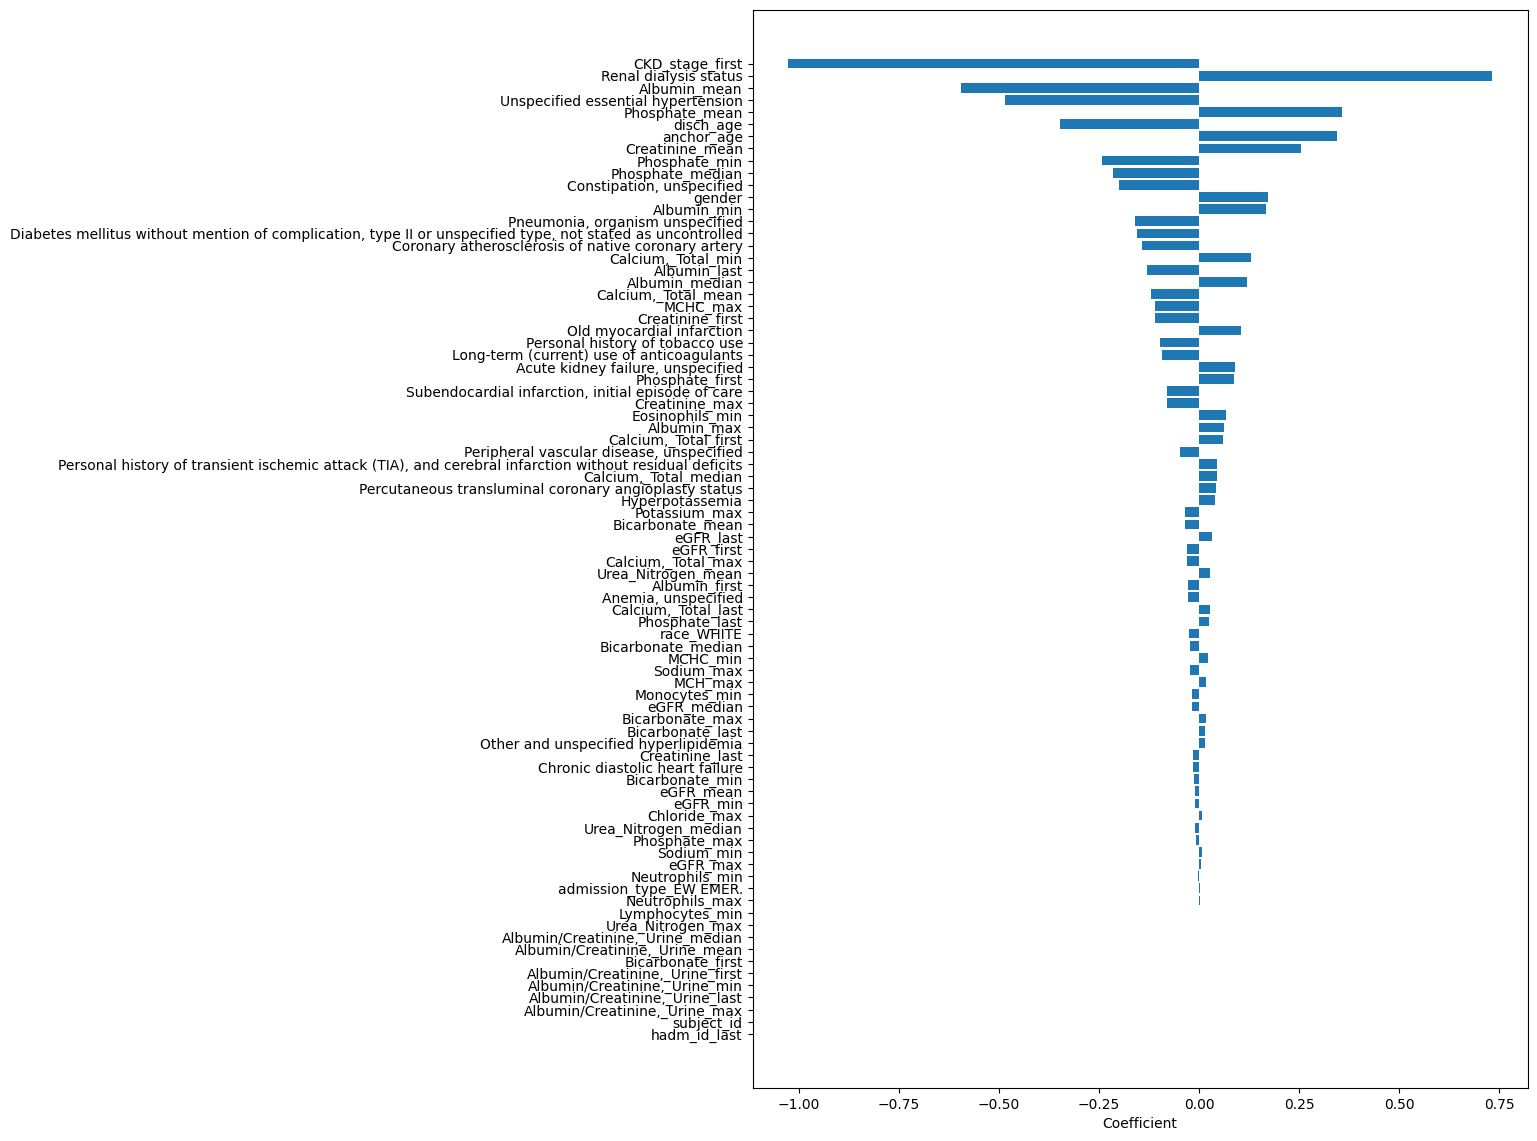

In [7]:
# Extract the coefficients and their corresponding feature names
coefficients = cph.params_
feature_importances = pd.DataFrame({
    'Feature': coefficients.index,
    'Coefficient': coefficients.values
})

# Sort the features by the absolute value of the coefficients
feature_importances['Abs_Coefficient'] = feature_importances['Coefficient'].abs()
feature_importances = feature_importances.sort_values(by='Abs_Coefficient', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 14))
plt.barh(feature_importances['Feature'], feature_importances['Coefficient'])
plt.xlabel('Coefficient')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top

# Save the plot as a PNG file
plt.savefig("figs/ResNetFeatures.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Schoenfeld Test

In [8]:
# Perform Schoenfeld test to assess the proportional hazards assumption
results = proportional_hazard_test(cph, train, time_transform='rank')
results_summary = results.summary

# Save the results summary to a CSV file
results_summary.to_csv('ResNetSchoenfeld.csv', index=True)

display(results_summary)

,test_statistic,p,-log2(p)
"Acute kidney failure, unspecified",0.582061,0.445506,1.166484
"Albumin/Creatinine,_Urine_first",0.006886,0.933865,0.098714
"Albumin/Creatinine,_Urine_last",0.014478,0.904226,0.145245
"Albumin/Creatinine,_Urine_max",0.022229,0.881480,0.182001
"Albumin/Creatinine,_Urine_mean",0.013612,0.907121,0.140633
...,...,...,...
eGFR_min,0.029493,0.863645,0.211489
gender,0.106078,0.744654,0.425358
hadm_id_last,0.146557,0.701847,0.510771
race_WHITE,0.345742,0.556533,0.845460


# Brier Score Plot

In [9]:
# Prepare the survival data in the format required by scikit-survival
survival_train = Surv.from_dataframe('stage_delta', 'duration', train)
survival_test = Surv.from_dataframe('stage_delta', 'duration', test)

# Prepare the feature data
X_train = train.drop(columns=['duration', 'stage_delta'])
X_test = test.drop(columns=['duration', 'stage_delta'])

# Predict the survival function for the test data using the fitted model
survival_functions = cph.predict_survival_function(X_test)

# Extract available times directly from the survival functions
available_times = survival_functions.index

# Ensure valid_times are strictly within the follow-up time range of the test data
test_duration_min, test_duration_max = test['duration'].min(), test['duration'].max()
valid_times = available_times[(available_times > test_duration_min) & (available_times < test_duration_max)]

# Extract survival probabilities at the specified time points
estimate = survival_functions.loc[valid_times].T.values

# Calculate Brier scores using scikit-survival
valid_times, brier_scores = brier_score(
    survival_train=survival_train,
    survival_test=survival_test,
    estimate=estimate,
    times=valid_times
)

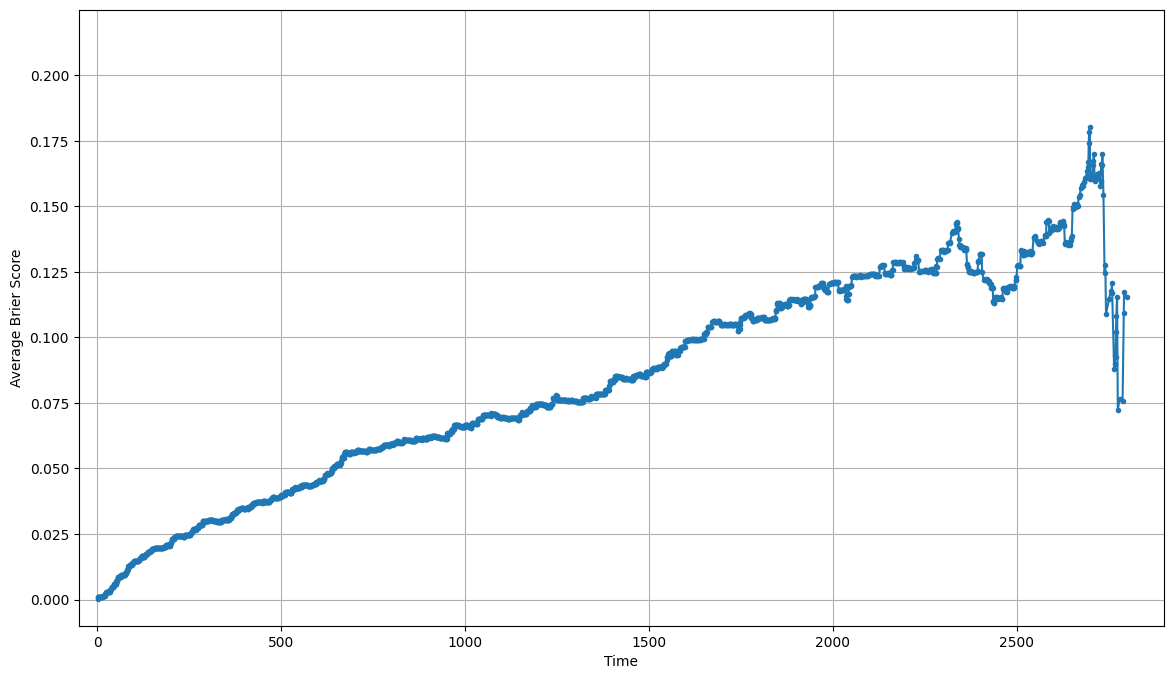

In [10]:
# Create a plot of Brier scores over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, brier_scores, marker='o', markersize=3)
plt.xlabel('Time')
plt.ylabel('Average Brier Score')
plt.yticks(np.arange(0, 0.225, 0.025))
plt.grid(True)
plt.xlim(-50, 2900)
plt.ylim(-0.01, 0.225)

# Save the plot as a PNG file
plt.savefig("figs/ResNetBrier.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Time-Dependent ROC Curves

In [11]:
# Predict risk scores for the test data using the fitted model
risk_scores = cph.predict_partial_hazard(X_test)

# Define time points to evaluate ROC curves
times = np.arange(1, test['duration'].max() + 1, 1)

# Ensure times are within the follow-up time range of the test data
valid_times = times[(times >= test['duration'].min()) & (times < test['duration'].max())]

# Compute time-dependent ROC curves using valid times
auc_values, mean_auc = cumulative_dynamic_auc(survival_train, survival_test, risk_scores, valid_times)

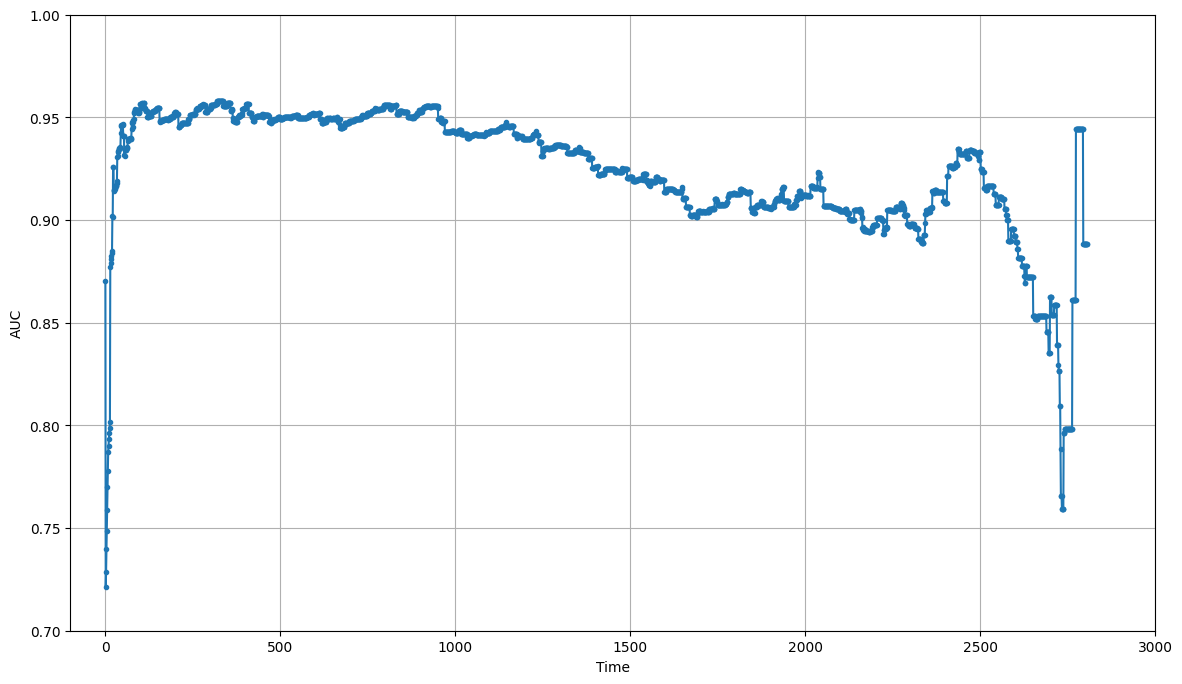

In [12]:
# Plot mean AUC over time
plt.figure(figsize=(14, 8))
plt.plot(valid_times, auc_values, marker='o', markersize=3)
plt.xlabel('Time')
plt.ylabel('AUC')
plt.grid(True)
plt.xlim(-100, 3000)
plt.ylim(0.70, 1.0)

# Save the plot as a PNG file
plt.savefig("figs/ResNetTimeDepAUC.png", format="png", dpi=300, bbox_inches="tight")

plt.show()

# Visualize the Survival Functions by CKD Stage

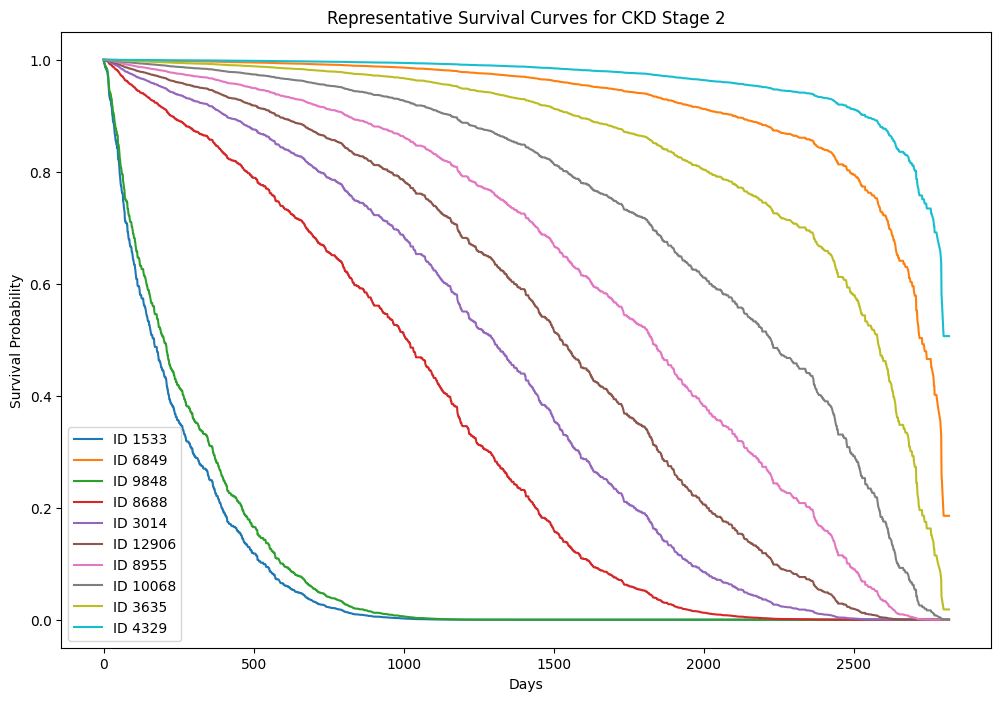

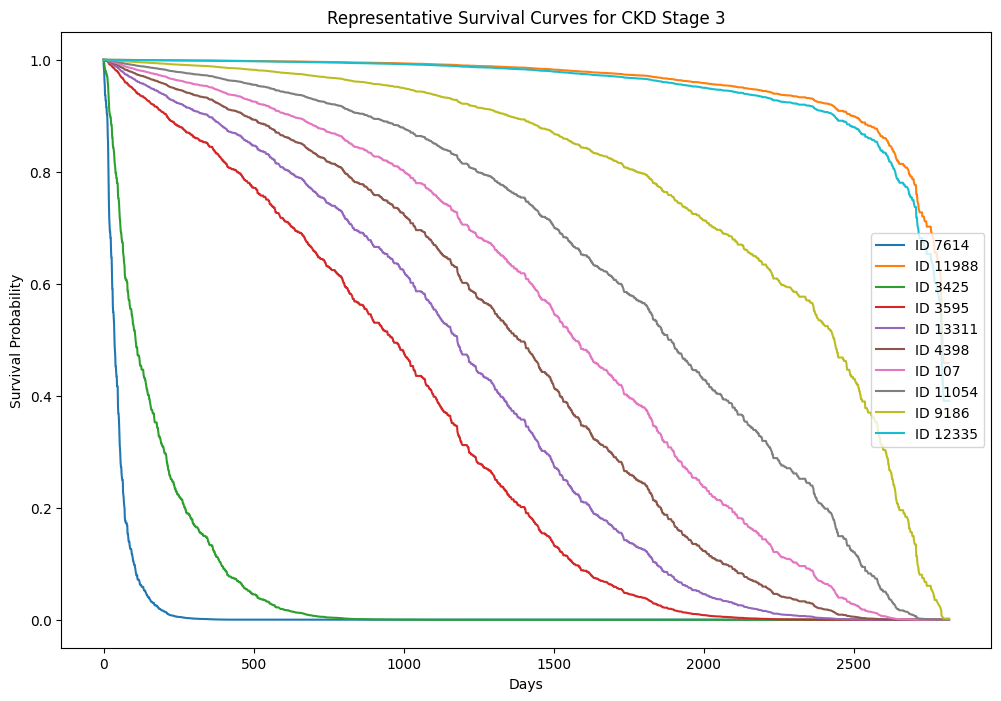

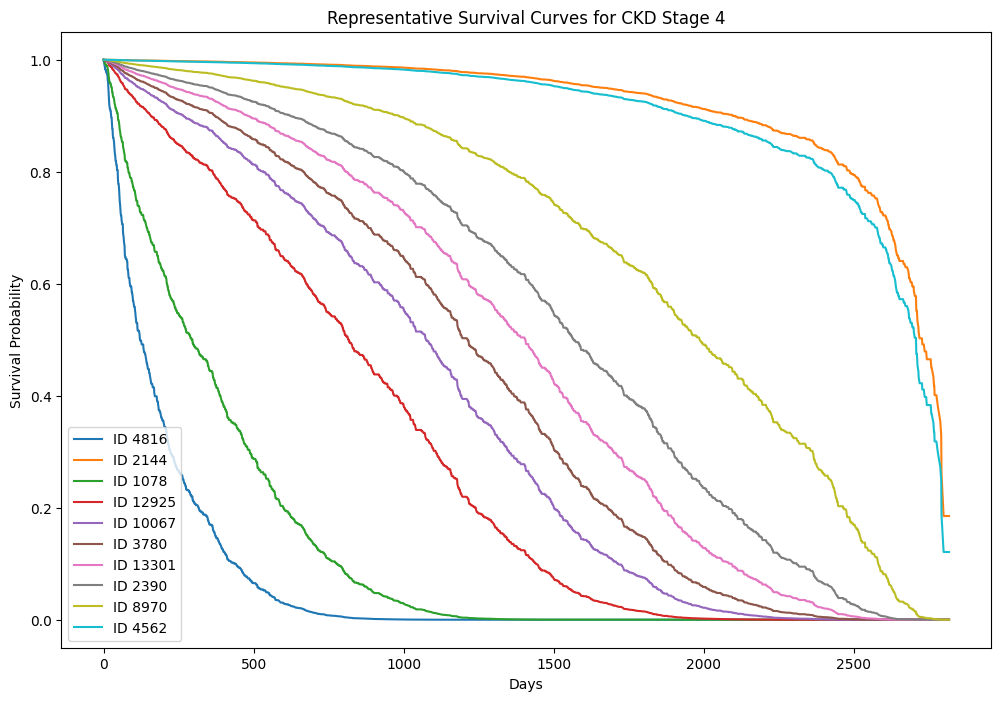

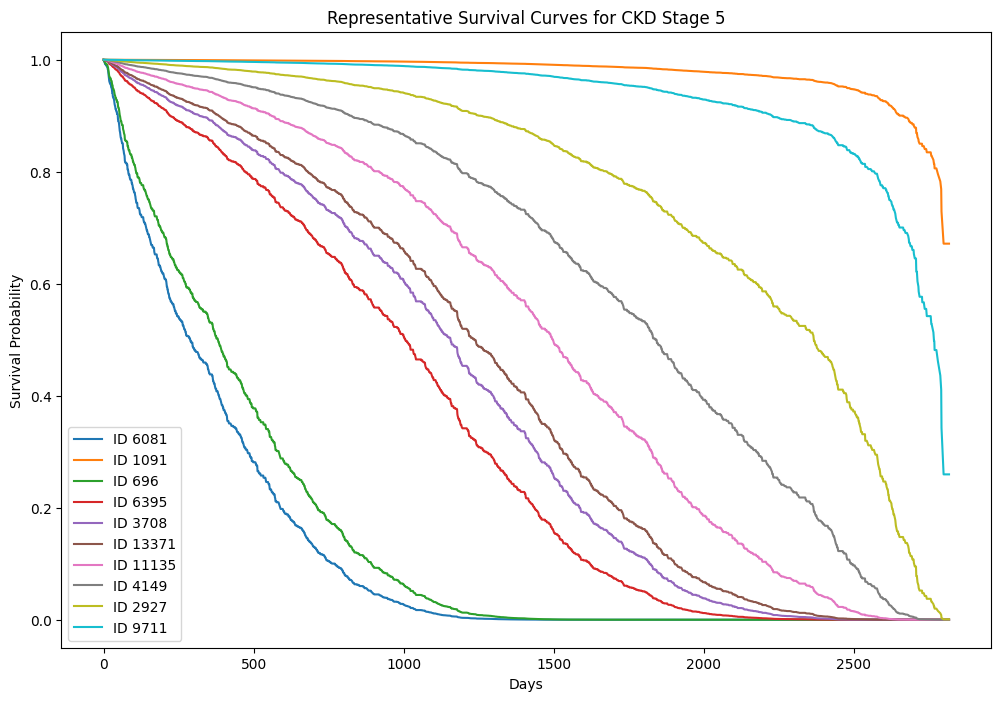

In [13]:
# Iterate through CKD stages 1 to 5 and plot the survival curves for each stage
for stage in range(2, 6):
    plot_survival_curves_for_stage(stage, 'ResNet', test, cph)